In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

In [3]:
train=pd.read_csv('/content/drive/MyDrive/colab전용/Auction_master_train.csv')
test=pd.read_csv('/content/drive/MyDrive/colab전용/Auction_master_test.csv')

pytorch_submission=pd.read_csv('/content/drive/MyDrive/colab전용/Auction_submission.csv')
lasso_submission=pd.read_csv('/content/drive/MyDrive/colab전용/Auction_submission.csv')
ridge_submission=pd.read_csv('/content/drive/MyDrive/colab전용/Auction_submission.csv')

데이터 전처리  

nan 값 제거 -> 주소관련

필요없는 열 정리 -> 

Auction_key 경매 아파트 고유 키값  
Auction_class 경매구분 강제경매 : 법원에 소송을 제기하여 판결을 얻은 후 집행권원에 따라 경매를 진행 임의경매 : 등기부등본 담보권(저당권, 가압류등)으로 경매를 진행    
Bid_class 입찰구분(일반/개별/일괄)  
Claim_price 경매 신청인의 청구 금액  
Appraisal_company 감정사  
Appraisal_date 감정일자    
Auction_count 총경매횟수   
Auction_miscarriage_count 총유찰횟수   
Total_land_gross_area 총토지전체면적(㎡)  
Total_land_real_area 총토지실면적(㎡)   
Total_land_auction_area 총토지경매면적(㎡)   
Total_building_area 총건물면적(㎡)   
Total_building_auction_area 총건물경매면적(㎡)  
Total_appraisal_price 총감정가   
Minimum_sales_price 최저매각가격, 입찰 시 입찰인이 최저로 제시해야만 하는 금액   
First_auction_date 최초경매일    
Final_auction_date 최종경매일   
Final_result 최종결과    
Creditor 채권자, 경매 신청인   
addr_do 주소_시도    
addr_si 주소_시군구    
addr_dong 주소_읍면동   
addr_li 주소_리     
addr_san 주소_산번지 여부(Y)    
addr_bunji1 주소_번지1   
addr_bunji2 주소_번지2    
addr_etc 주소_기타주소    
Apartment_usage 건물(토지)의 대표 용도   
Completion_date 준공일    
Preserve_regist_date 보존등기일, 건물을 신축하고 처음으로 등기   
Total_floor 총층수   
Current_floor 현재층수    
Specific 기타_특이사항    
Share_auction_YorN 지분경매 여부(Y), 하나의 부동산이 전체가 아닌 일부만 경매가 진행 (하나의 부동산의 공유자가 지분으로 소유권을 가지고 있을 때 그중 일부 지분만 경매가 진행)     
road_name 도로명주소_도로명    
road_bunji1 도로명주소_번지1   
road_bunji2 도로명주소_번지2    
Close_date 종국일자     
Close_result 종국결과, 낙찰과 배당의 차이 : 경매 진행은 ①경매진행(낙찰) ▷ ②낙찰허가결정 ▷ ③대금납부 ▷ ④배당 후 종결 로 이뤄집니다. 낙찰자가 최고가로 입찰(①)해서 낙찰허가(②)를 받으면 대금납부기한 낙찰금을 입금(③)합니다. 법원은 납부된 낙찰금을 가지고 채권자에게 순위에 의한 배당(④)을 해주고 경매는 종결됩니다.     
point.y 위도    
point.x 경도   
Hammer_price 낙찰가   

방법 1. ~~숫자 열로만 해보기 ~~ 1억9천만.   
방법 2. ~~숫자 열 중 상관성이 많이 없는걸로만 해보기 ~~ ridge,lasso 모두 3억5천.  
방법 3. ~~임의,강제 같은 경우에 따라 바뀔 수 있으니 범주형 포함해서 해보기 ~~ 트리를 생각했는데 pycaret돌리니 선형모델이 더 좋다.  
방법 4.~~월별 Hammer_price 보고, 시간도 변수 넣어서 해보기~~ 별로 좋은 방법 아닌거같다.   
방법 5. ~~아파트 정보(돈, 위치, 공부해서 더 보기.)~~ 선형모델이 좋은것 같으므로 더 연구.

In [ ]:
# 방법 1.
tmp_train=train.select_dtypes(exclude='object')
tmp_test=test.select_dtypes(exclude='object')

In [ ]:
# nan 값. 처리
cols=['addr_bunji1','addr_bunji2','road_bunji1','road_bunji2']

tmp_train=tmp_train.drop(cols,axis=1)
tmp_test=tmp_test.drop(cols,axis=1)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

In [ ]:
# 11개의 특성과 1개의 답
x_train=tmp_train.drop(['Auction_key','Hammer_price','point.x','point.y','Current_floor'],axis=1)
y_train=tmp_train['Hammer_price']
x_test=tmp_test.drop(['Auction_key','Hammer_price','point.x','point.y','Current_floor'],axis=1)

In [ ]:
from sklearn.preprocessing import StandardScaler

encoder=StandardScaler()

for col in x_train.columns:
    x_train[col]=encoder.fit_transform(x_train[col].values.reshape(-1,1))
    x_test[col]=encoder.fit_transform(x_test[col].values.reshape(-1,1))
display(x_train.head())
display(x_test.head())

,Claim_price,Auction_count,Auction_miscarriage_count,Total_land_gross_area,Total_land_real_area,Total_land_auction_area,Total_building_area,Total_building_auction_area,Total_appraisal_price,Minimum_sales_price,Total_floor
0,1.043456,0.174819,0.254466,-0.233008,-0.076371,-0.060591,0.802970,0.820282,0.430194,0.503488,2.947348
1,-0.162572,0.174819,0.254466,0.083594,-0.361243,-0.344977,0.206615,0.226845,0.731268,0.880500,5.577111
2,-0.268455,1.240831,1.457112,1.219281,0.439278,0.454179,-0.437249,-0.413869,-0.480651,-0.674955,-0.208368
3,-0.139668,0.174819,0.254466,-0.107866,-0.143337,-0.127442,-0.108261,-0.086491,-0.265452,-0.367618,0.317585
4,-0.242615,0.174819,0.254466,-0.358203,0.043615,0.059191,-0.107791,-0.086023,-0.415862,-0.555965,-1.049892


,Claim_price,Auction_count,Auction_miscarriage_count,Total_land_gross_area,Total_land_real_area,Total_land_auction_area,Total_building_area,Total_building_auction_area,Total_appraisal_price,Minimum_sales_price,Total_floor
0,0.490222,5.34605,5.950794,-0.647578,-0.086055,-0.959754,0.370874,0.405242,-0.539687,-0.837689,-0.267088
1,0.490222,4.30497,4.800325,-0.647578,-0.089839,-1.033034,0.137139,0.176709,-0.577740,-0.790260,-0.267088
2,0.490222,5.34605,5.950794,-0.647578,-0.086055,-0.959754,0.370874,0.405242,-0.527660,-0.831956,-0.267088
3,0.490222,5.34605,5.950794,-0.647578,-0.086055,-0.959754,0.370874,0.405242,-0.527660,-0.831956,-0.267088
4,0.490222,5.34605,5.950794,-0.647578,-0.086055,-0.959754,0.370874,0.405242,-0.527660,-0.831956,-0.267088


In [ ]:
# 데이터 정의
x_train=torch.FloatTensor(x_train.values)
y_train=torch.FloatTensor(y_train.values.reshape(-1,1))

dataset=TensorDataset(x_train,y_train)
dataloader=DataLoader(dataset,batch_size=10,shuffle=True)

# 모델 초기화
model=nn.Linear(11,1)

# optimizer 설정 
optimizer = optim.SGD(model.parameters(),lr=0.001)

# 원하는만큼 경사 하강법을 반복
for epoch in range(101):
    for batch_idx,samples in enumerate(dataloader):
        # 데이터
        x_train,y_train=samples
        # 가설
        y_pred=model(x_train)
        # cost 계산
        cost=F.mse_loss(y_pred,y_train)
        # cost로 가설 개선
        optimizer.zero_grad() # 미분 누적 초기화
        cost.backward() # 미분값 자동 계산
        optimizer.step() # w,b gradient 업데이트.
        # 로그 출력
        print(f"Epoch : {epoch}/100, batch : {batch_idx+1}/{len(dataloader)}, Cost : {cost.item()}")

In [ ]:
pred=model(torch.FloatTensor(x_test.values))
pytorch_submission['Hammer_price']=pred.detach().numpy()
pytorch_submission.head()

,Auction_key,Hammer_price
0,1778,18491942.0
1,1779,40987236.0
2,1784,23228316.0
3,1786,23228316.0
4,1790,23228316.0


In [ ]:
# 방법2.종속성제거
from sklearn.linear_model import Ridge,Lasso

# 11개의 특성과 1개의 답
x_train=tmp_train.drop(['Auction_key','Hammer_price','point.x','point.y','Current_floor'],axis=1)
y_train=tmp_train['Hammer_price']
x_test=tmp_test.drop(['Auction_key','Hammer_price','point.x','point.y','Current_floor'],axis=1)

ridge_model=Ridge(alpha=0.01,random_state=71)
lasso_model=Ridge(alpha=0.01,random_state=71)

ridge_model.fit(x_train,y_train)
lasso_model.fit(x_train,y_train)

ridge_pred=ridge_model.predict(x_test)
lasso_pred=lasso_model.predict(x_test)

ridge_submission['Hammer_price']=ridge_pred
lasso_submission['Hammer_price']=lasso_pred

display(ridge_submission.head())
display(lasso_submission.head())

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.75937e-21): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.75937e-21): result may not be accurate.
  overwrite_a=True).T


,Auction_key,Hammer_price
0,1778,2.113086e+08
1,1779,2.142934e+08
2,1784,2.137562e+08
3,1786,2.137562e+08
4,1790,2.137562e+08


,Auction_key,Hammer_price
0,1778,2.113086e+08
1,1779,2.142934e+08
2,1784,2.137562e+08
3,1786,2.137562e+08
4,1790,2.137562e+08


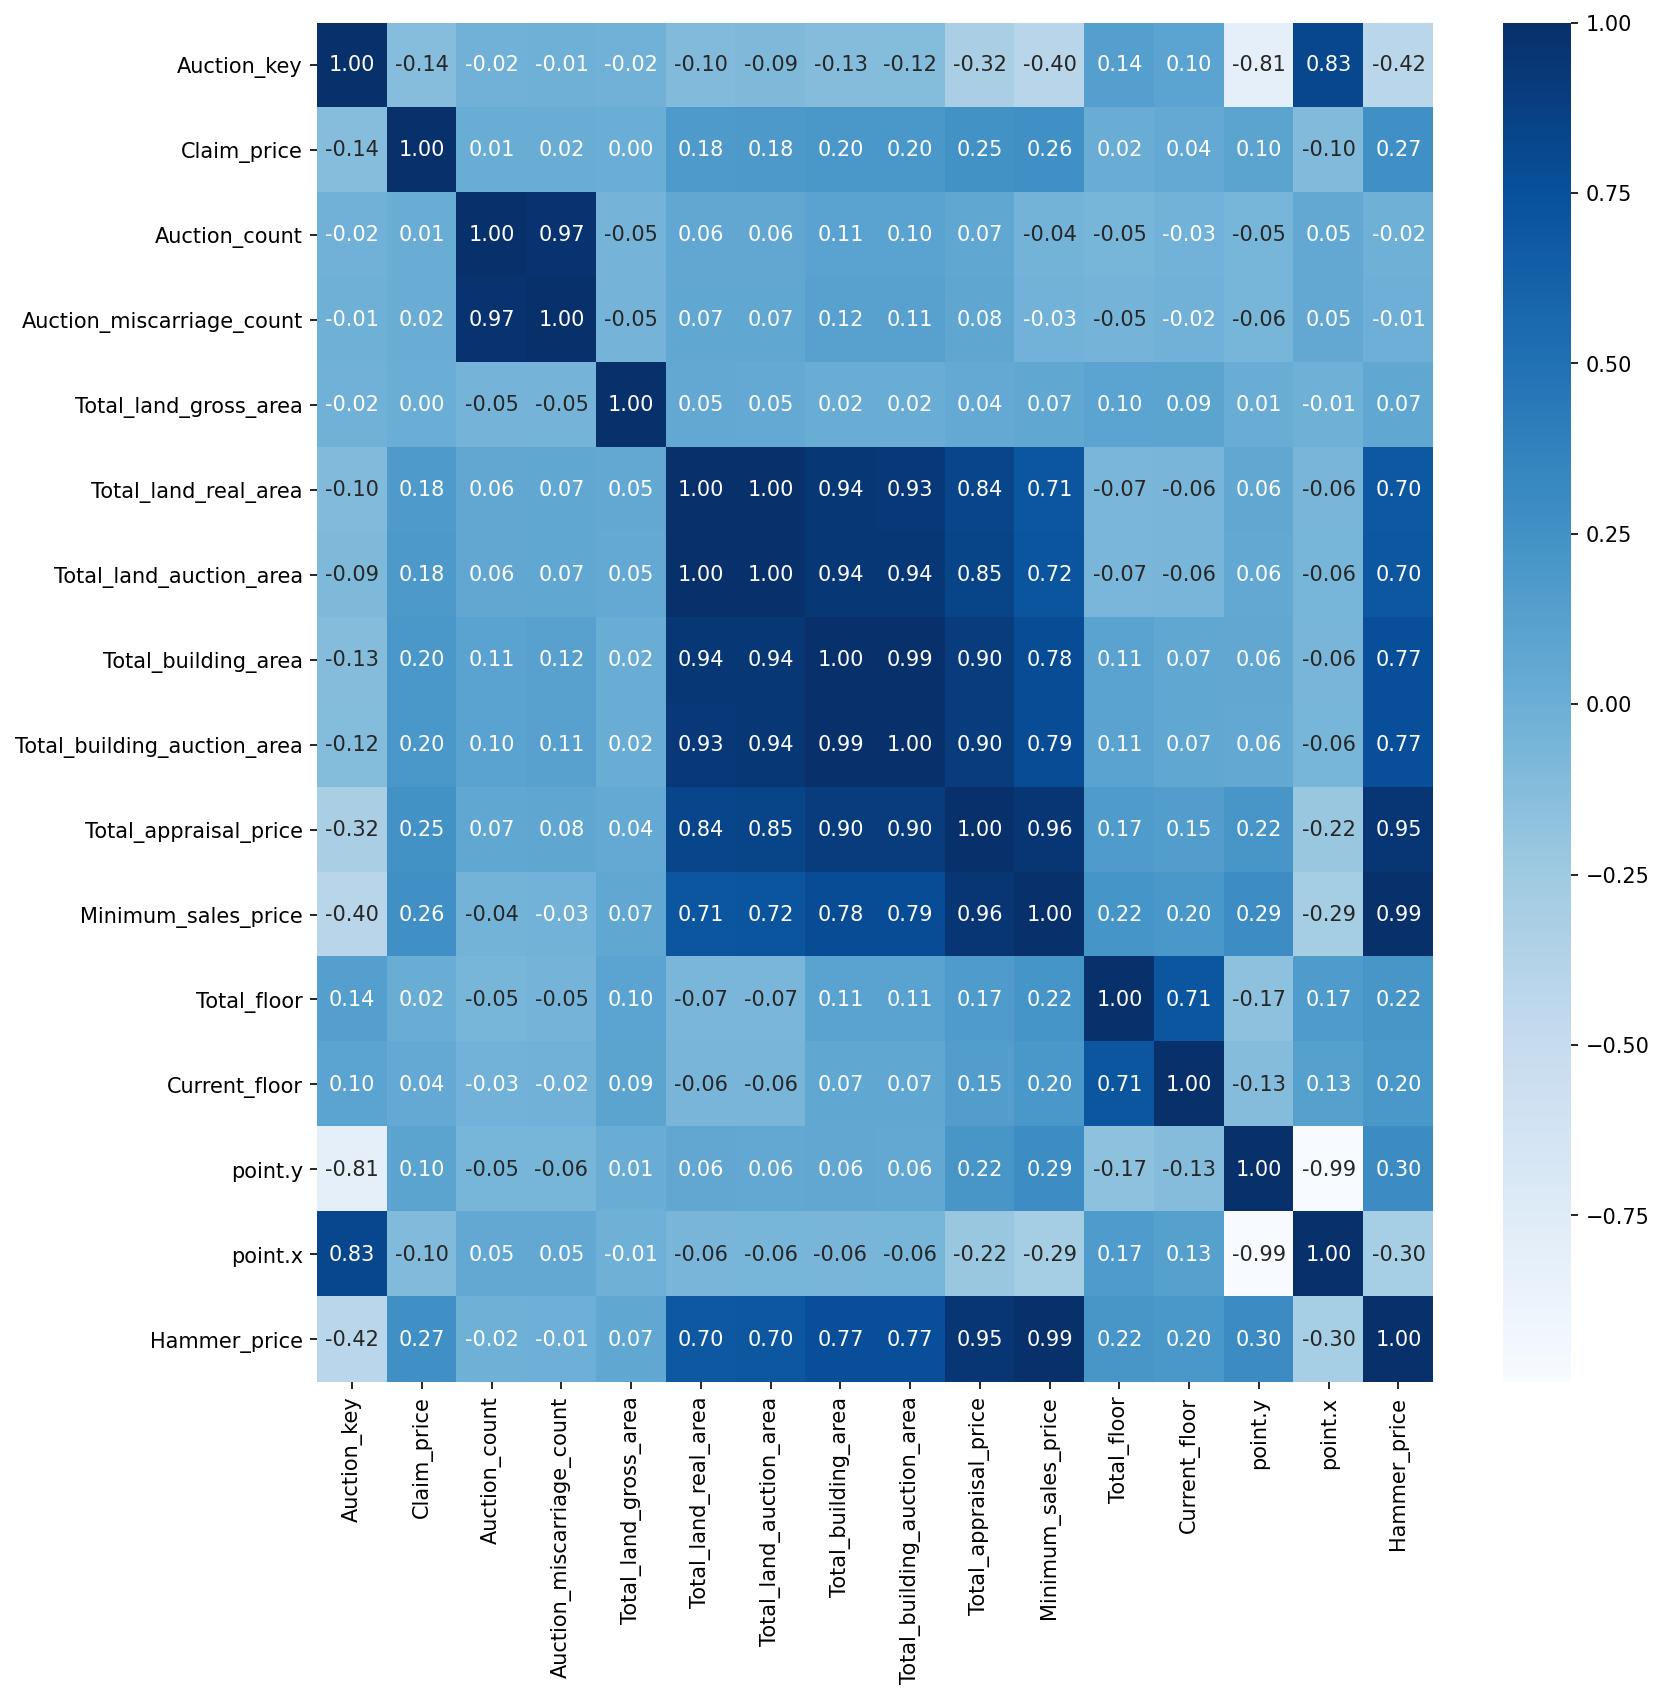

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(12,12),dpi=150)
sns.heatmap(tmp_train.corr(),annot=True,fmt='.2f',cmap='Blues',ax=ax)
plt.show()

In [ ]:
# 종속성 제거
cols=['Total_land_gross_area','Total_land_auction_area','Total_building_area',
      'Total_building_auction_area','Total_appraisal_price','Minimum_sales_price',
      'Auction_key','point.x','point.y','Current_floor','addr_bunji1','addr_bunji2',
      'road_bunji1','road_bunji2','Appraisal_date','Close_date','Preserve_regist_date',
      'addr_etc','Specific','road_name','addr_san','addr_li','First_auction_date','Final_auction_date',
      'Final_result','Auction_miscarriage_count','Total_land_real_area']


tmp_train=train.drop(cols,axis=1)
tmp_test=test.drop(cols,axis=1)
display(tmp_train.shape)
display(tmp_train.head())

(1933, 14)

,Auction_class,Bid_class,Claim_price,Appraisal_company,Auction_count,Creditor,addr_do,addr_si,addr_dong,Apartment_usage,Total_floor,Share_auction_YorN,Close_result,Hammer_price
0,임의,개별,1766037301,정명감정,2,베리타스자산관리대부,부산,해운대구,우동,주상복합,45,N,배당,760000000
1,임의,일반,152946867,희감정,2,흥국저축은행,부산,해운대구,우동,아파트,70,N,배당,971889999
2,임의,개별,11326510,혜림감정,3,국민은행,부산,사상구,모라동,아파트,15,N,배당,93399999
3,임의,일반,183581724,신라감정,2,고려저축은행,부산,남구,대연동,아파트,20,N,배당,256899000
4,강제,일반,45887671,나라감정,2,Private,부산,사하구,괴정동,아파트,7,N,배당,158660000


In [ ]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

cols=tmp_train.select_dtypes(include='object').columns

tmp_train[cols]=tmp_train[cols].apply(lambda row:le.fit_transform(row))
tmp_test[cols]=tmp_test[cols].apply(lambda row:le.fit_transform(row))
display(tmp_train.head())
display(tmp_test.head())

,Auction_class,Bid_class,Claim_price,Appraisal_company,Auction_count,Creditor,addr_do,addr_si,addr_dong,Apartment_usage,Total_floor,Share_auction_YorN,Close_result,Hammer_price
0,1,0,1766037301,181,2,157,0,38,205,1,45,0,1,760000000
1,1,2,152946867,237,2,444,0,38,205,0,70,0,1,971889999
2,1,0,11326510,233,3,76,0,20,88,0,15,0,1,93399999
3,1,2,183581724,128,2,59,0,10,58,0,20,0,1,256899000
4,0,2,45887671,46,2,37,0,21,21,0,7,0,1,158660000


,Auction_class,Bid_class,Claim_price,Appraisal_company,Auction_count,Creditor,addr_do,addr_si,addr_dong,Apartment_usage,Total_floor,Share_auction_YorN,Close_result,Hammer_price
0,0,0,1087000000,48,7,16,0,15,32,1,15,0,1,0
1,0,0,1087000000,48,6,16,0,15,32,1,15,0,1,0
2,0,0,1087000000,48,7,16,0,15,32,1,15,0,1,0
3,0,0,1087000000,48,7,16,0,15,32,1,15,0,1,0
4,0,0,1087000000,48,7,16,0,15,32,1,15,0,1,0


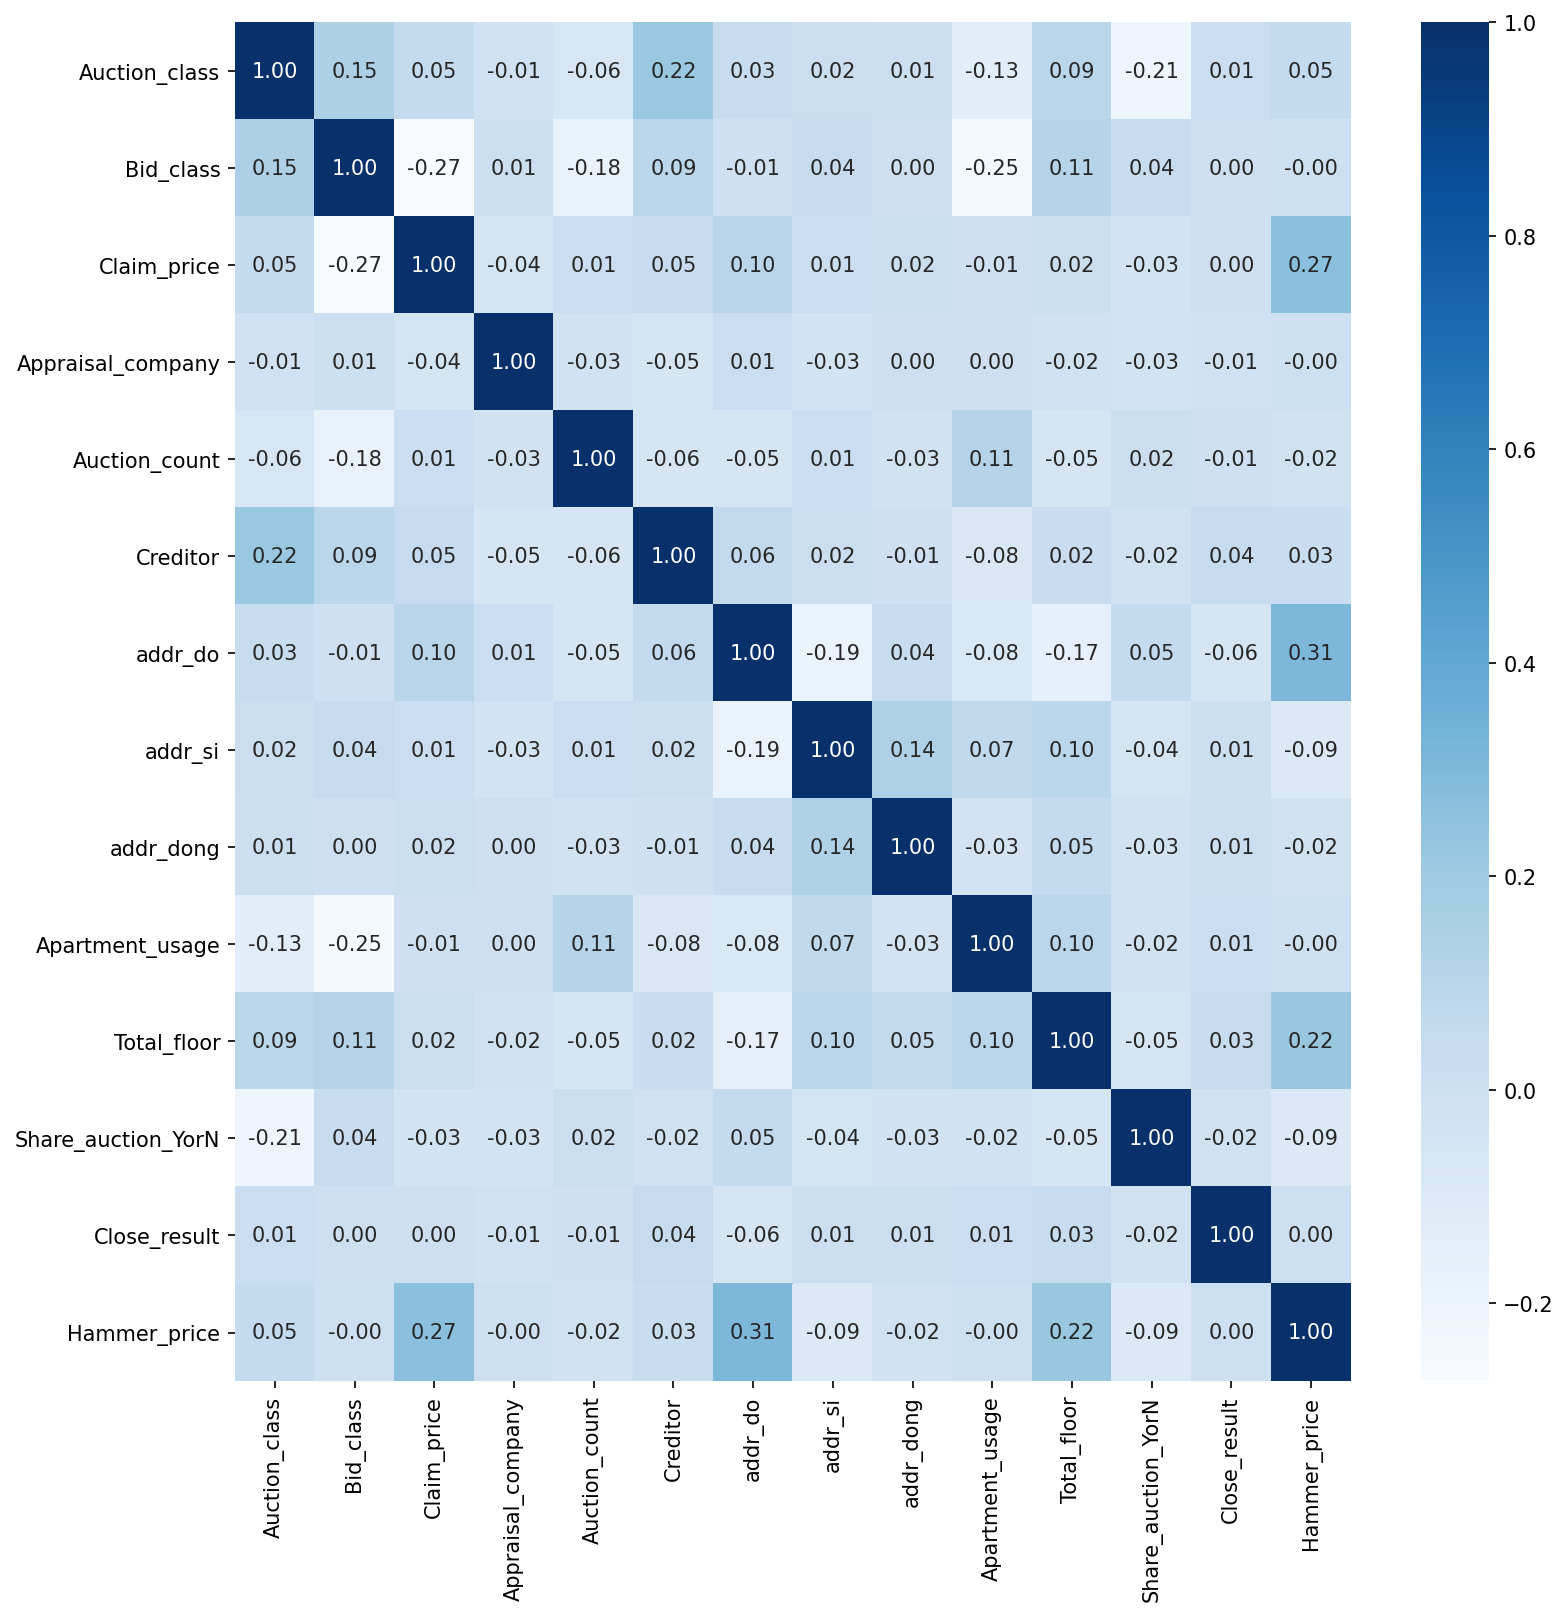

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(12,12),dpi=150)
sns.heatmap(tmp_train.corr(),annot=True,fmt='.2f',cmap='Blues',ax=ax)
plt.show()

In [ ]:
from sklearn.linear_model import Ridge,Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

x_train=tmp_train.drop('Hammer_price',axis=1)
y_train=tmp_train.Hammer_price
x_test=tmp_test.drop('Hammer_price',axis=1)

X_tr,X_val,y_tr,y_val=train_test_split(x_train,y_train,test_size=0.2,random_state=71)

ridge_model=Ridge(alpha=0.01,random_state=71,max_iter=10000,tol=1)

ridge_model.fit(X_tr,y_tr)

ridge_val=ridge_model.predict(X_val)
print(f"Score : {np.sqrt(mean_squared_error(ridge_val,y_val))}")

Score : 804418621.8194734


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.01313e-21): result may not be accurate.
  overwrite_a=True).T


In [ ]:
pred=ridge_model.predict(x_test)
ridge_submission['Hammer_price']=pred
ridge_submission.head()

,Auction_key,Hammer_price
0,1778,1.457429e+08
1,1779,1.536811e+08
2,1784,1.457429e+08
3,1786,1.457429e+08
4,1790,1.457429e+08


In [ ]:
from sklearn.linear_model import Ridge,Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

x_train=tmp_train.drop('Hammer_price',axis=1)
y_train=tmp_train.Hammer_price
x_test=tmp_test.drop('Hammer_price',axis=1)

X_tr,X_val,y_tr,y_val=train_test_split(x_train,y_train,test_size=0.2,random_state=71)

lasso_model=Lasso(alpha=0.01,random_state=71,max_iter=10000,tol=1)

lasso_model.fit(X_tr,y_tr)

ridge_val=lasso_model.predict(X_val)
print(f"Score : {np.sqrt(mean_squared_error(ridge_val,y_val))}")

Score : 804505767.8679192


In [ ]:
pred=lasso_model.predict(x_test)
lasso_submission['Hammer_price']=pred
lasso_submission.head()

,Auction_key,Hammer_price
0,1778,1.116085e+08
1,1779,1.222212e+08
2,1784,1.116085e+08
3,1786,1.116085e+08
4,1790,1.116085e+08


In [ ]:
# pytorch_submission.to_csv('/content/drive/MyDrive/colab전용/pytorch_20200114.csv',index=False)
# ridge_submission.to_csv('/content/drive/MyDrive/colab전용/ridge_20200114.csv',index=False)
# lasso_submission.to_csv('/content/drive/MyDrive/colab전용/lasso_20200114.csv',index=False)

In [4]:
# 방법3. tree를 통한 모든 변수

cols=['First_auction_date','Final_auction_date','Close_date','point.x','point.y',
      'addr_li','addr_bunji1','addr_bunji2','Specific','road_bunji1','road_bunji2']
train=train.drop(cols,axis=1)
test=test.drop(cols,axis=1)

from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()
cols=train.select_dtypes(include='object').columns

train[cols]=train[cols].apply(lambda row:le.fit_transform(row))
test[cols]=test[cols].apply(lambda row:le.fit_transform(row))

In [9]:
x_train=train.drop(['Auction_key'],axis=1)
y_train=train['Hammer_price']
x_test=test.drop(['Auction_key','Hammer_price'],axis=1)

display(x_train.shape,y_train.shape,x_test.shape)

(1933, 29)

(1933,)

(829, 28)

In [ ]:
# !pip install pycaret

In [11]:
# 준비
from pycaret.regression import *

# regression
reg=setup(data=x_train,target='Hammer_price')

# best
best_5=compare_models(sort='RMSE',n_select=5)

# blend
blended=blend_models(estimator_list=best_5,fold=5)

# hold_out
pred_holdout=predict_model(blended)

# final
final_model=finalize_model(blended)

# predict
pred=predict_model(final_model,data=x_test)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,3.267924e+07,3.884231e+15,6.232360e+07,0.9752,0.1280,0.0898
1,2.918160e+07,2.053069e+15,4.531080e+07,0.9890,0.1248,0.0796
2,3.197762e+07,2.949370e+15,5.430811e+07,0.9781,0.1609,0.0976
3,4.047625e+07,3.078393e+16,1.754535e+08,0.9711,0.1471,0.0845
4,3.543878e+07,5.966294e+15,7.724179e+07,0.9723,0.1831,0.0950
Mean,3.395070e+07,9.127379e+15,8.292756e+07,0.9771,0.1488,0.0893
SD,3.822333e+06,1.090599e+16,4.743837e+07,0.0064,0.0216,0.0066


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,2.935983e+07,2.177936e+15,4.666836e+07,0.9897,0.1614,0.0912


In [15]:
submission=pd.read_csv('/content/drive/MyDrive/colab전용/Auction_submission.csv')

In [21]:
submission['Hammer_price']=pred['Label']
submission.head()

,Auction_key,Hammer_price
0,1778,1.325550e+08
1,1779,1.372000e+08
2,1784,1.337489e+08
3,1786,1.333434e+08
4,1790,1.325250e+08


In [22]:
# submission.to_csv('/content/drive/MyDrive/colab전용/baseline3_20210114.csv',index=False)